# Exercise 6
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-06-02: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')
from pprint import pprint
from scipy.special import factorial

# Notebook graphics settings: 
#%config InlineBackend.figure_format = 'svg'     # inline vector graphics
%config InlineBackend.figure_format = 'png'     # inline vector graphics
#%config InlineBackend.figure_format = 'retina' # medium resolution png:s
plt.rcParams['figure.dpi'] = 300               # custom dpi setting png

## Task 1: Poisson latent variable models

In [2]:
# Import and extract the matrices and vectors.
import scipy.io
mat = scipy.io.loadmat('ex6file.mat')

print(mat.keys())
A     = mat['A']
B     = mat['B']
gamma = mat['Gamma']
sigma = mat['Sigma']
mu0   = mat['mu0']
n0    = mat['n0']
u     = mat['u']

mu0 = mu0.flatten()
n0 = n0.flatten()

dict_keys(['__header__', '__version__', '__globals__', 'A', 'B', 'Gamma', 'Sigma', 'mu0', 'n0', 'u'])


(2, 100)


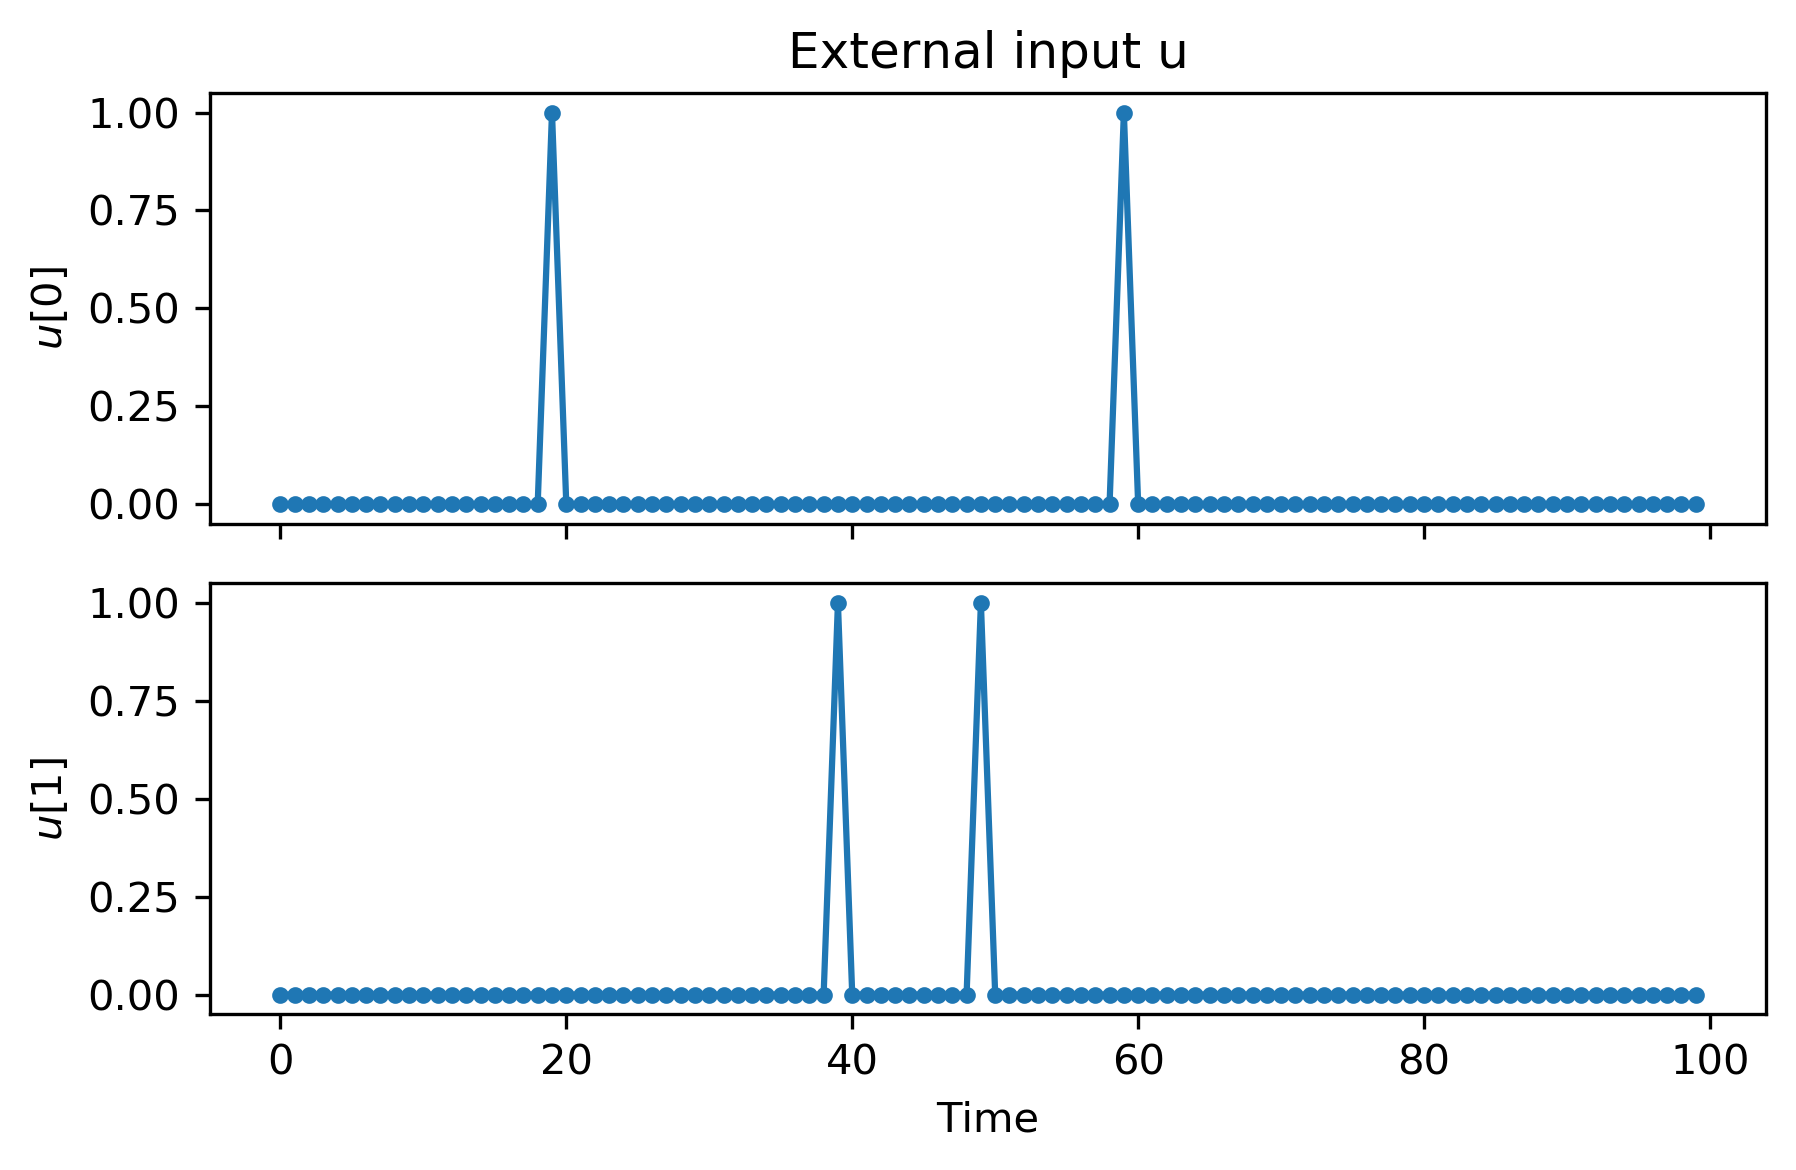

In [3]:
print(u.shape)

# Plotting the external inputs u.
fig, ax = plt.subplots(u.shape[0], 1, sharex=True)
ax = ax.flatten()
for i in range(u.shape[0]):
    ax[i].plot(u[i], '.-')
    ax[i].set_ylabel(f'$u[{i}]$')
ax[-1].set_xlabel('Time')
ax[0].set_title('External input u')
fig.tight_layout()
plt.show()

# Transpose for easier python notation
u = u.T

In [4]:
T  = 100
dt = 1
N, M = gamma.shape

# Pre-allocation
z = np.zeros((T, M))
c = np.zeros((T, N))
lam = np.zeros_like(c)

# Process noise 
eps = np.random.multivariate_normal(np.zeros(M), sigma, size=T)

# Initial conditions
z[0]   = np.random.multivariate_normal(mu0, sigma)
lam[0] = np.exp(np.log(n0) + gamma @ z[0])
c[0]   = np.random.poisson(lam[0]*dt)

# Generate a Poisson time series
for t in range(1, T):
    z[t]   = A @ z[t-1] + B @ u[t] + eps[t]
    lam[t] = np.exp(np.log(n0) + gamma @ z[t])
    c[t]   = np.random.poisson(lam[t]*dt)

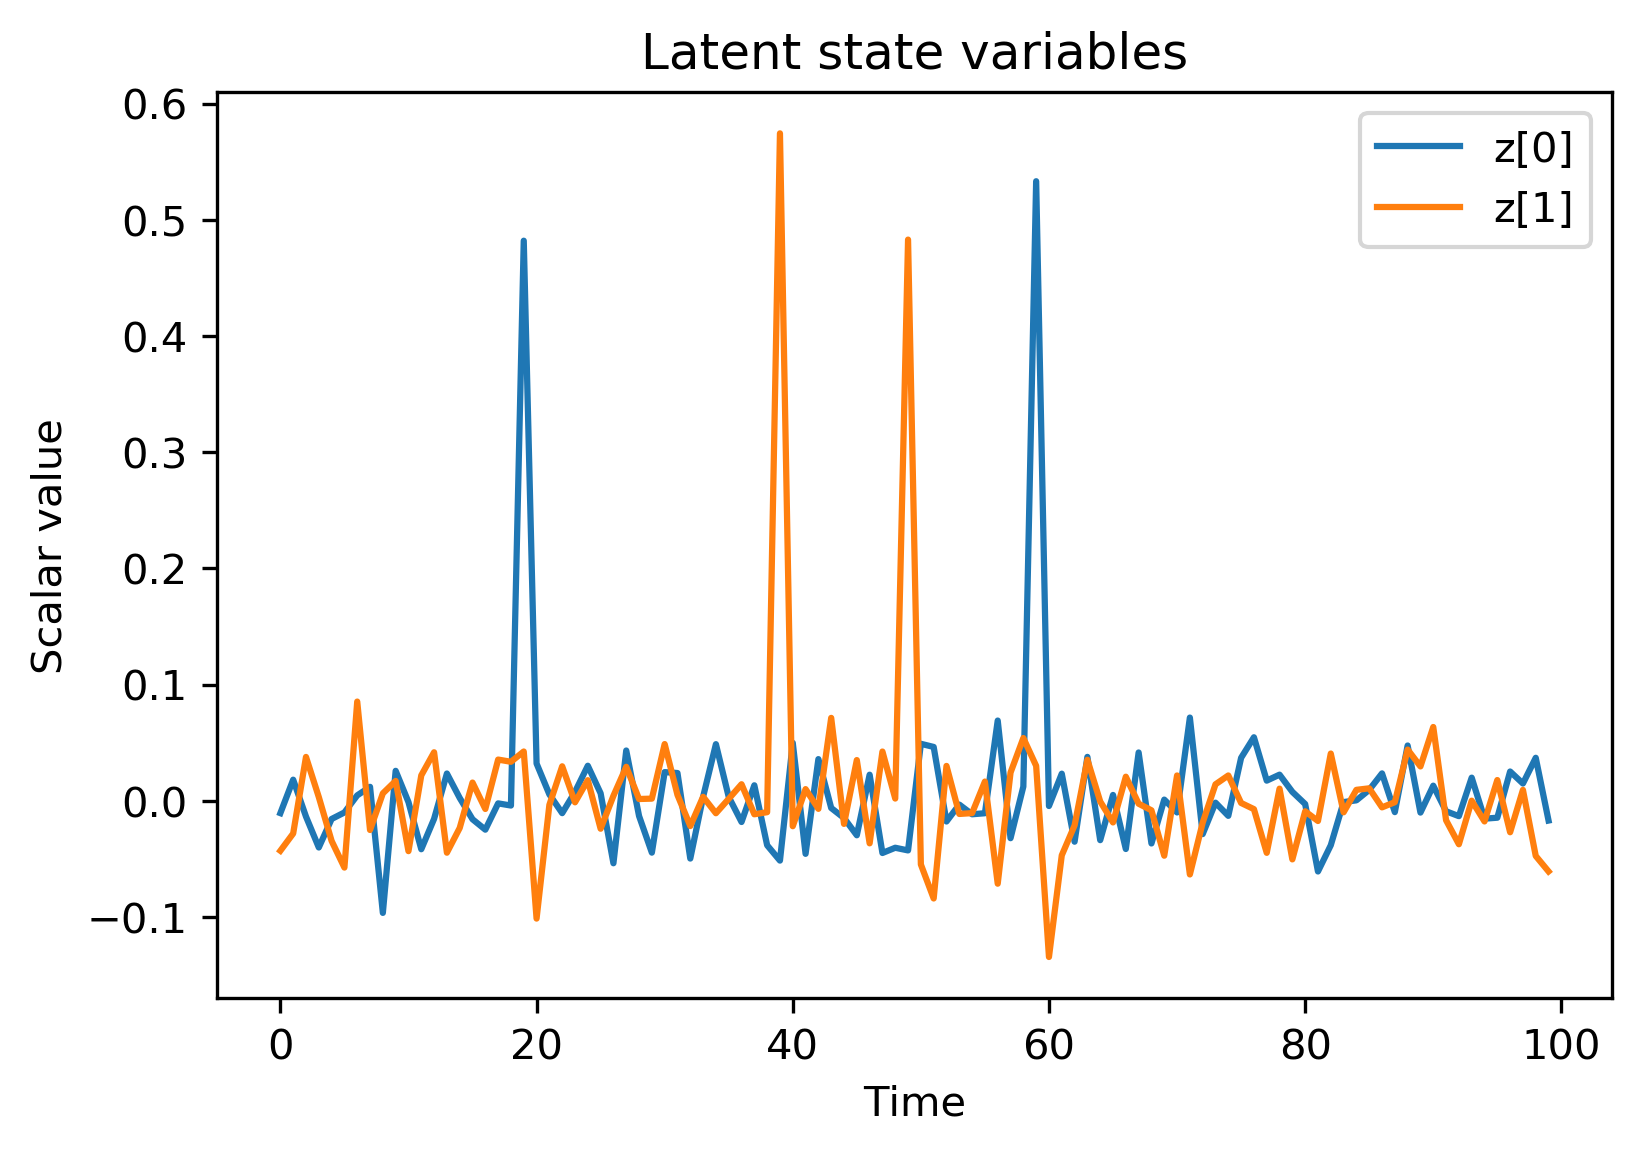

In [5]:
# Plotting the latent state variables z.
for i in range(M):
    plt.plot(z[:, i], label=f'z[{i}]')
plt.ylabel('Scalar value')
plt.xlabel('Time')
plt.title('Latent state variables')
plt.legend()
plt.show()

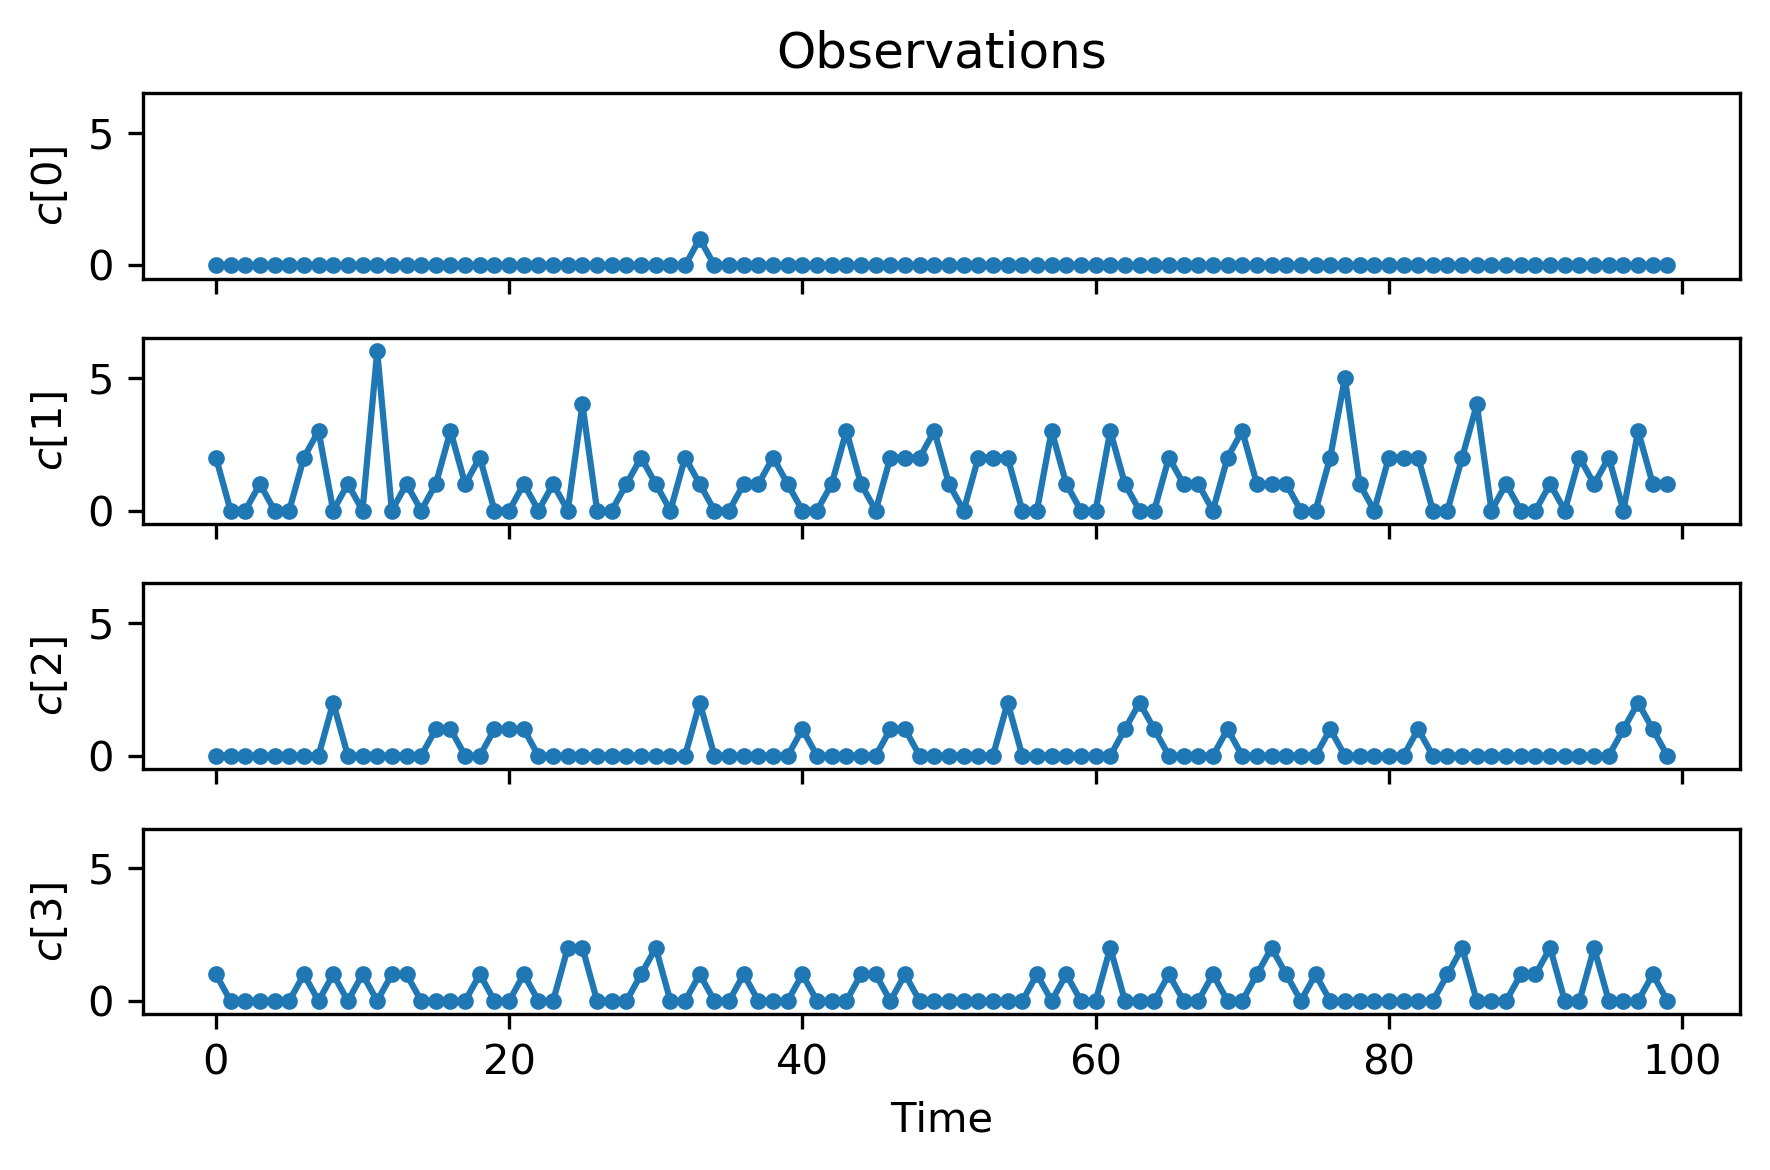

In [6]:
# Plotting the observations c.
fig, ax = plt.subplots(N, 1, sharex=True)
ax = ax.flatten()
for i in range(N):
    ax[i].plot(c[:, i], '.-')
    ax[i].set_ylabel(f'$c[{i}]$')
    ax[i].set_ylim([-0.5, np.max(c)+0.5])
ax[-1].set_xlabel('Time')
ax[0].set_title('Observations')
fig.tight_layout()
plt.show()

In [7]:
# Joint data log-likelihood of the generated Poisson series.
from scipy.special import factorial

sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)

logL_initcond = -0.5*M*np.log(2*np.pi) - 0.5*np.log(sigma_det) - 0.5*(z[0]-mu0).T @ sigma_inv @ (z[0]-mu0)
logL_trsmodel = -0.5*M*(T-1)*np.log(2*np.pi) - 0.5*(T-1)*np.log(sigma_det) - 0.5*np.trace(eps[1:] @ sigma_inv @ eps[1:].T)
logL_obsmodel = np.sum(c*np.log(lam*dt) - np.log(factorial(c)) - lam*dt)
logL = logL_initcond + logL_trsmodel + logL_obsmodel
print(f"Joint data log-likelihood of the generated Poisson series: {logL:.6}")

Joint data log-likelihood of the generated Poisson series: 110.936


## Task 2: Fixed points, stability and bifurcations.

In [8]:
def nonlinear_map(x, w, theta):
    return w * sigmoid(x) + theta

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Fixpoint approximately at x = 4.41441


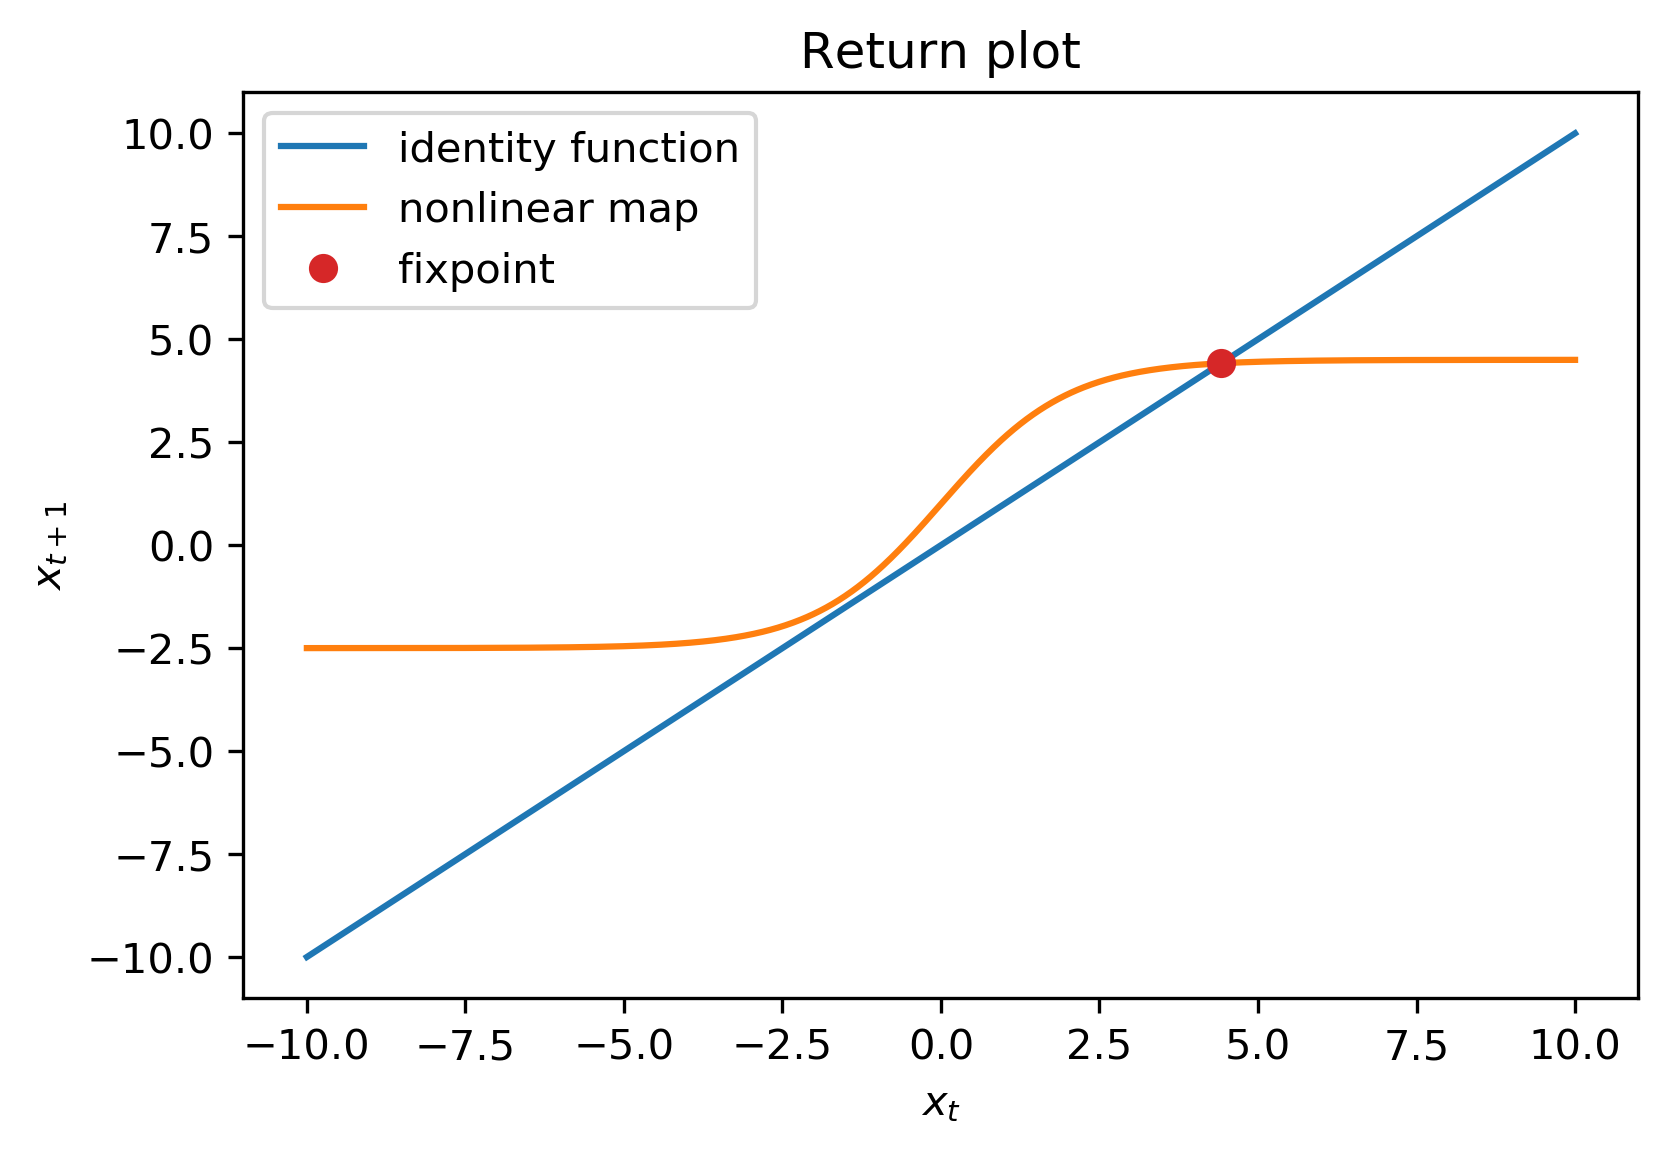

In [9]:
w = 7
theta = -2.5 
x = np.linspace(-10, 10, 1000)
x_out = nonlinear_map(x, w, theta)

# Find the (singular) pixpoint
x_fix = x[np.argmin((x_out - x)**2)]
print(f'Fixpoint approximately at x = {x_fix:.6}')

# Visualize
plt.plot(x, x, label='identity function')
plt.plot(x, x_out, label='nonlinear map')
plt.plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint')
plt.xlabel('$x_t$')
plt.ylabel('$x_{t+1}$')
plt.title('Return plot')
plt.legend()
plt.show()

Since the absolute value slope of the nonlinear map at the fixpoint is less than one, the fixpoint will be stable. We can easily check this by computing the gradient at the fixpoint, which corresponds to
\begin{equation}
    \frac{\partial x_{t+1}}{\partial x_t} = \frac{\partial f(x_{t}, w, \theta)}{\partial x_t} = \frac{\partial}{\partial x_t} \left(w \sigma(x_t) + \theta \right) = w\frac{\partial \sigma(x_t)}{\partial x_t} = w\sigma(x_t) (1-\sigma(x_t))
\end{equation}
which at the fixpoint approximately equals:

In [10]:
grad_fixpoint = w * sigmoid(x_fix) * (1-sigmoid(x_fix))
print(f'Slope at fixpoint = {grad_fixpoint:.5}')

Slope at fixpoint = 0.082698


Which is in absolute value way less than unity, and thus stable. Also, one can generate various cobweb diagrams to get a feel for the dynamical system.

In [11]:
def cobweb(x, y_min):
    T = len(x)
    x_out = np.zeros(2*T-1)
    y_out = np.zeros(2*T-1)
    x_out[0], y_out[0] = x[0], y_min 
    for i in range(1, T):
        x_out[2*i-1], y_out[2*i-1] = x[i-1], x[i] 
        x_out[2*i], y_out[2*i] = x[i], x[i]
    return x_out, y_out

In [12]:
def iterate_time(x0, T, w, theta):
    x = np.zeros(T)
    x[0] = x0
    for t in range(1, T):
        x[t] = nonlinear_map(x[t-1], w, theta)
    return x

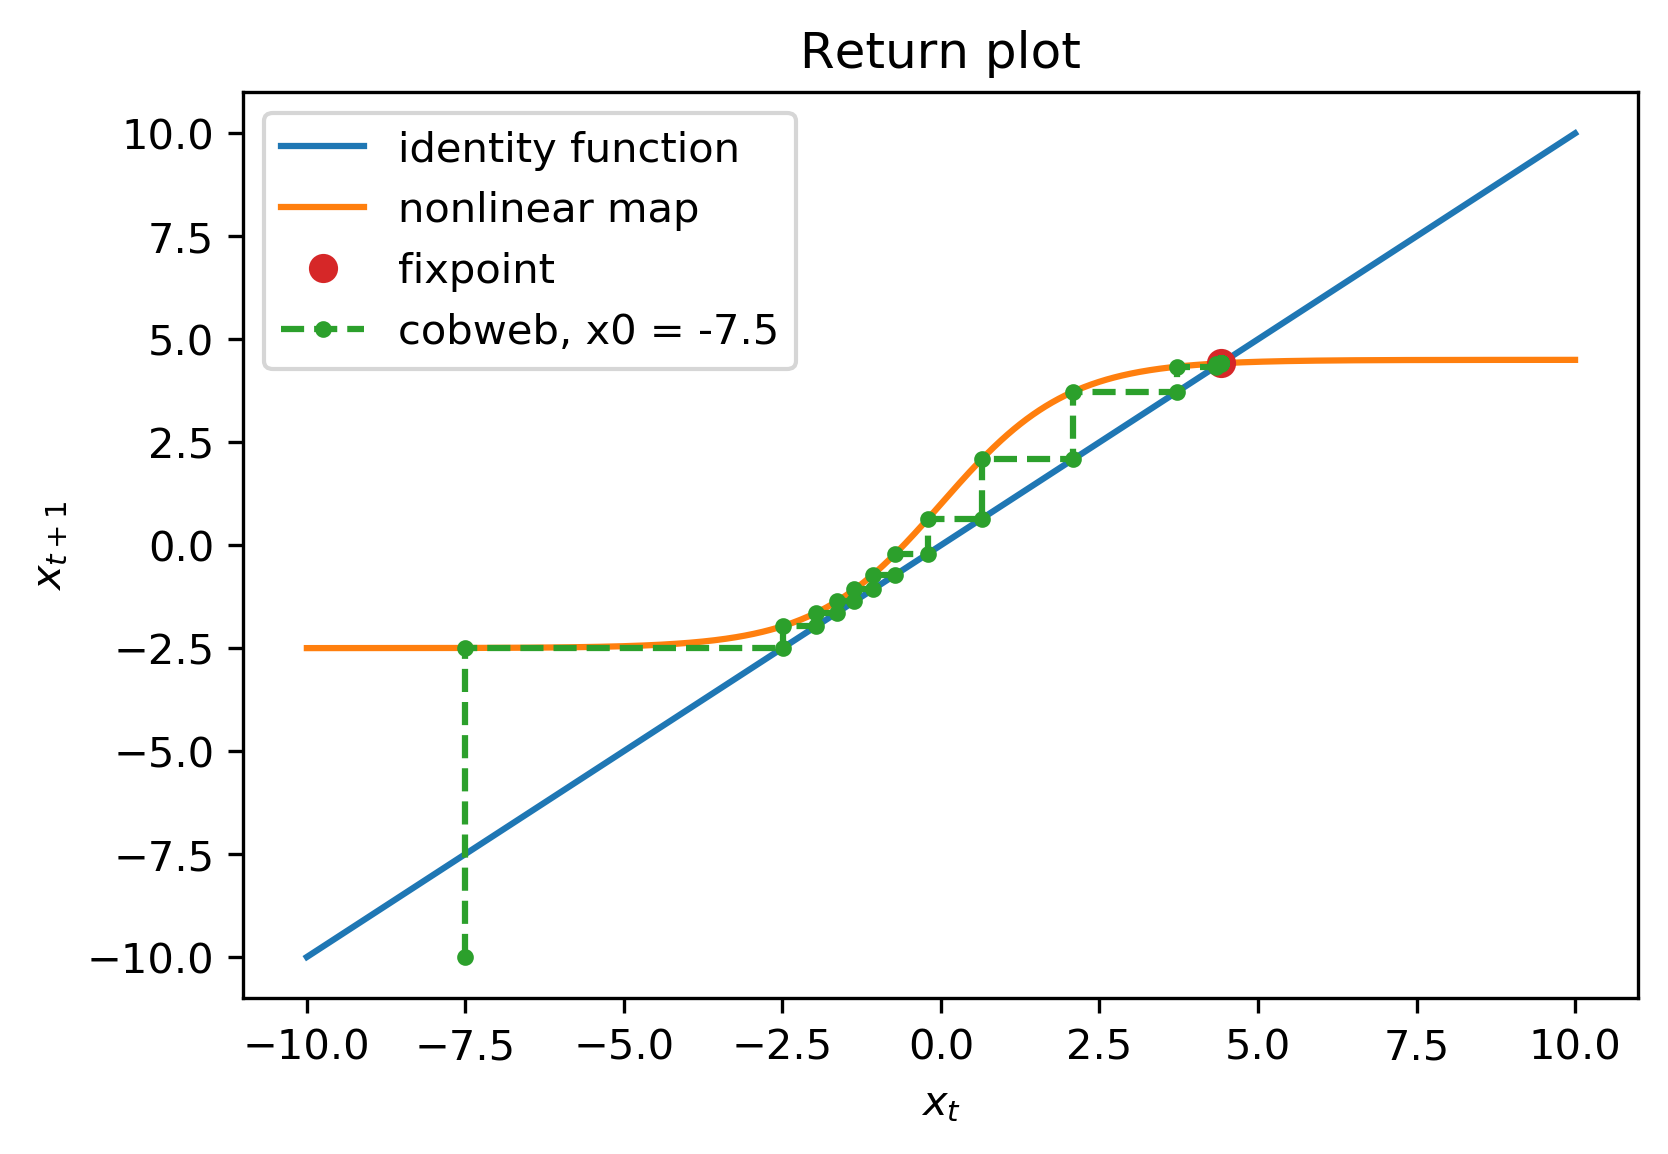

In [13]:
# Generate a time series given the starting position x0, and its cobweb diagram.
xt = iterate_time(x0=-7.5, T=30, w=7, theta=-2.5)
x_cobw, y_cobw = cobweb(xt, y_min=-10)

# Visualize
plt.plot(x, x, label='identity function')
plt.plot(x, x_out, label='nonlinear map')
plt.plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint')
plt.plot(x_cobw, y_cobw, '.--', label=f'cobweb, x0 = {x_cobw[0]}')

plt.xlabel('$x_t$')
plt.ylabel('$x_{t+1}$')
plt.title('Return plot')
plt.legend()
plt.show()

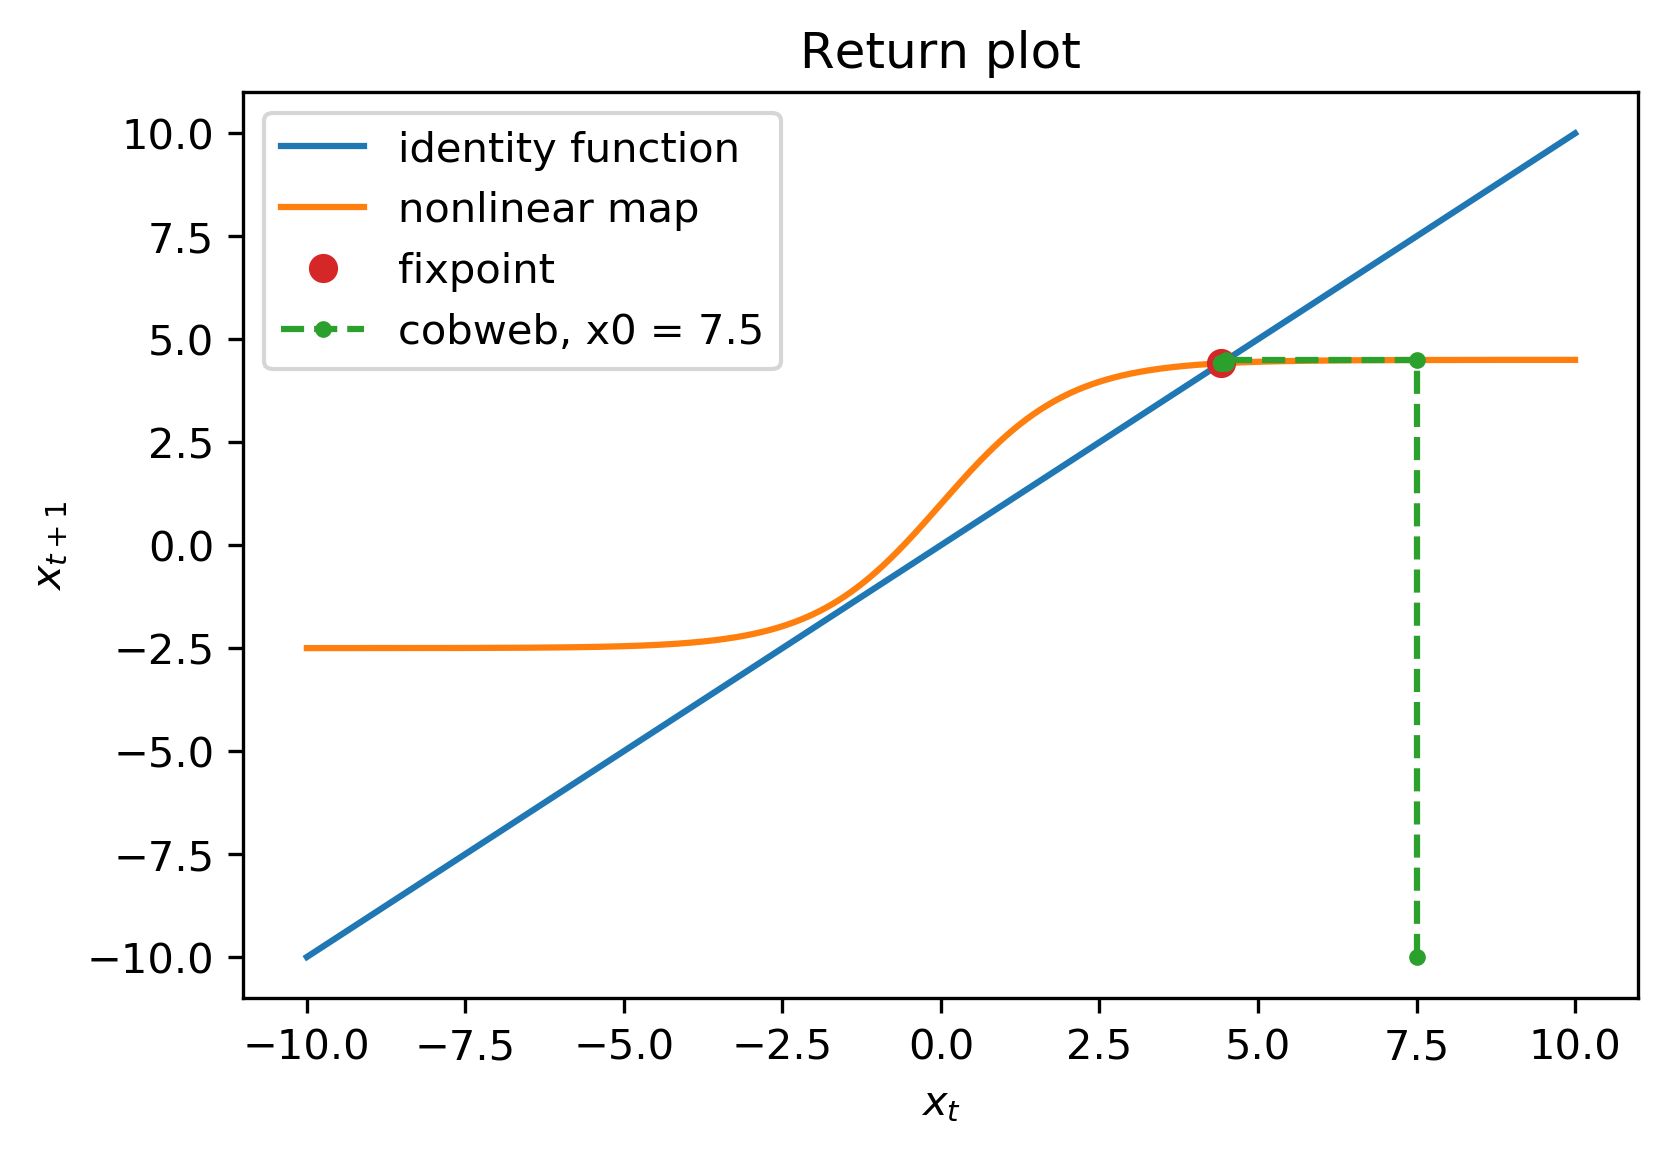

In [14]:
# Generate a time series given the starting position x0, and its cobweb diagram.
xt = iterate_time(x0=7.5, T=30, w=7, theta=-2.5)
x_cobw, y_cobw = cobweb(xt, y_min=-10)

# Visualize
plt.plot(x, x, label='identity function')
plt.plot(x, x_out, label='nonlinear map')
plt.plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint')
plt.plot(x_cobw, y_cobw, '.--', label=f'cobweb, x0 = {x_cobw[0]}')

plt.xlabel('$x_t$')
plt.ylabel('$x_{t+1}$')
plt.title('Return plot')
plt.legend()
plt.show()

#### Bifurcation diagram, $w = 7$, $\theta \in [-10, 0]$:

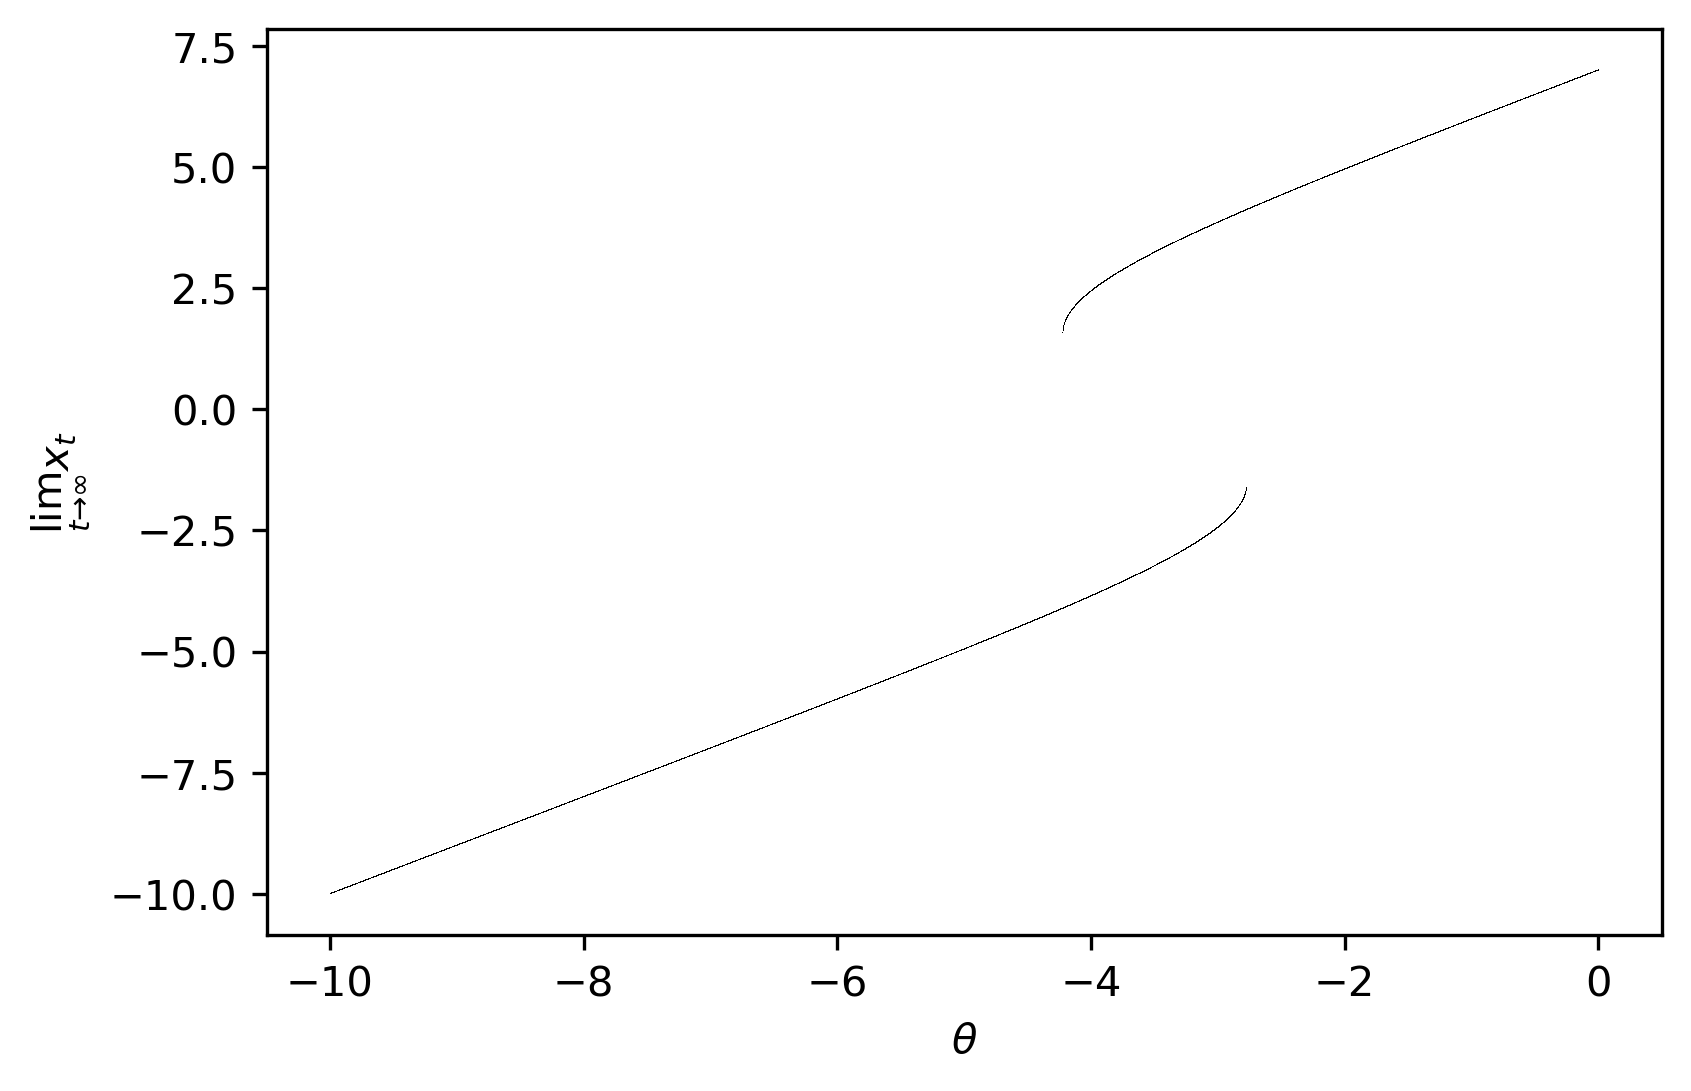

In [21]:
w = 7
theta = np.linspace(-10, 0, 10000) 
iterations = 1000                
display_last = 400               

x0_range = np.linspace(-10, 10, 20)
for x0 in x0_range: 
    x = np.ones_like(theta) * x0
    for i in range(iterations):
        x = nonlinear_map(x, w, theta)
        if i >= (iterations - display_last):
            plt.plot(theta, x, ',k', alpha=0.5)
        
plt.xlabel('$\\theta$')
plt.ylabel('$\lim_{t \\to \infty} x_t$')
plt.show()

## Task 3: Nonlinear systems, oscillations and chaos.

To find the fixpoint of the 'Ricker map', i.e.
\begin{equation}
    x_{t+1} = r x_t e^{-x_t}
\end{equation}
for $x_t, r \in \mathbb{R}$, we let $x_{t+1} = x_t$ and solve for $x$, as per
\begin{align}
   x_{t} &= r x_t e^{-x_t}\\
    \Longrightarrow 0 &= r x_t e^{-x_t} - x_t\\
    &= x_t \left( re^{-x_t} -1 \right).
\end{align}
Thus we have our first fixpoint at $x^*_1 = 0$, or 
\begin{align}
    0 &= re^{-x_t} - 1\\
    \Longrightarrow x &= \log(r),
\end{align}
which gives us our second fixpoint as $x^*_2 = \log(r)$, which will coincide with the first fixpoint when $r=1$.

In [23]:
def ricker_map(x, r):
    return r * x * np.exp(-x)

In [37]:
def ricker_diff(x, r):
    return -r * np.exp(-x) * (x-1)

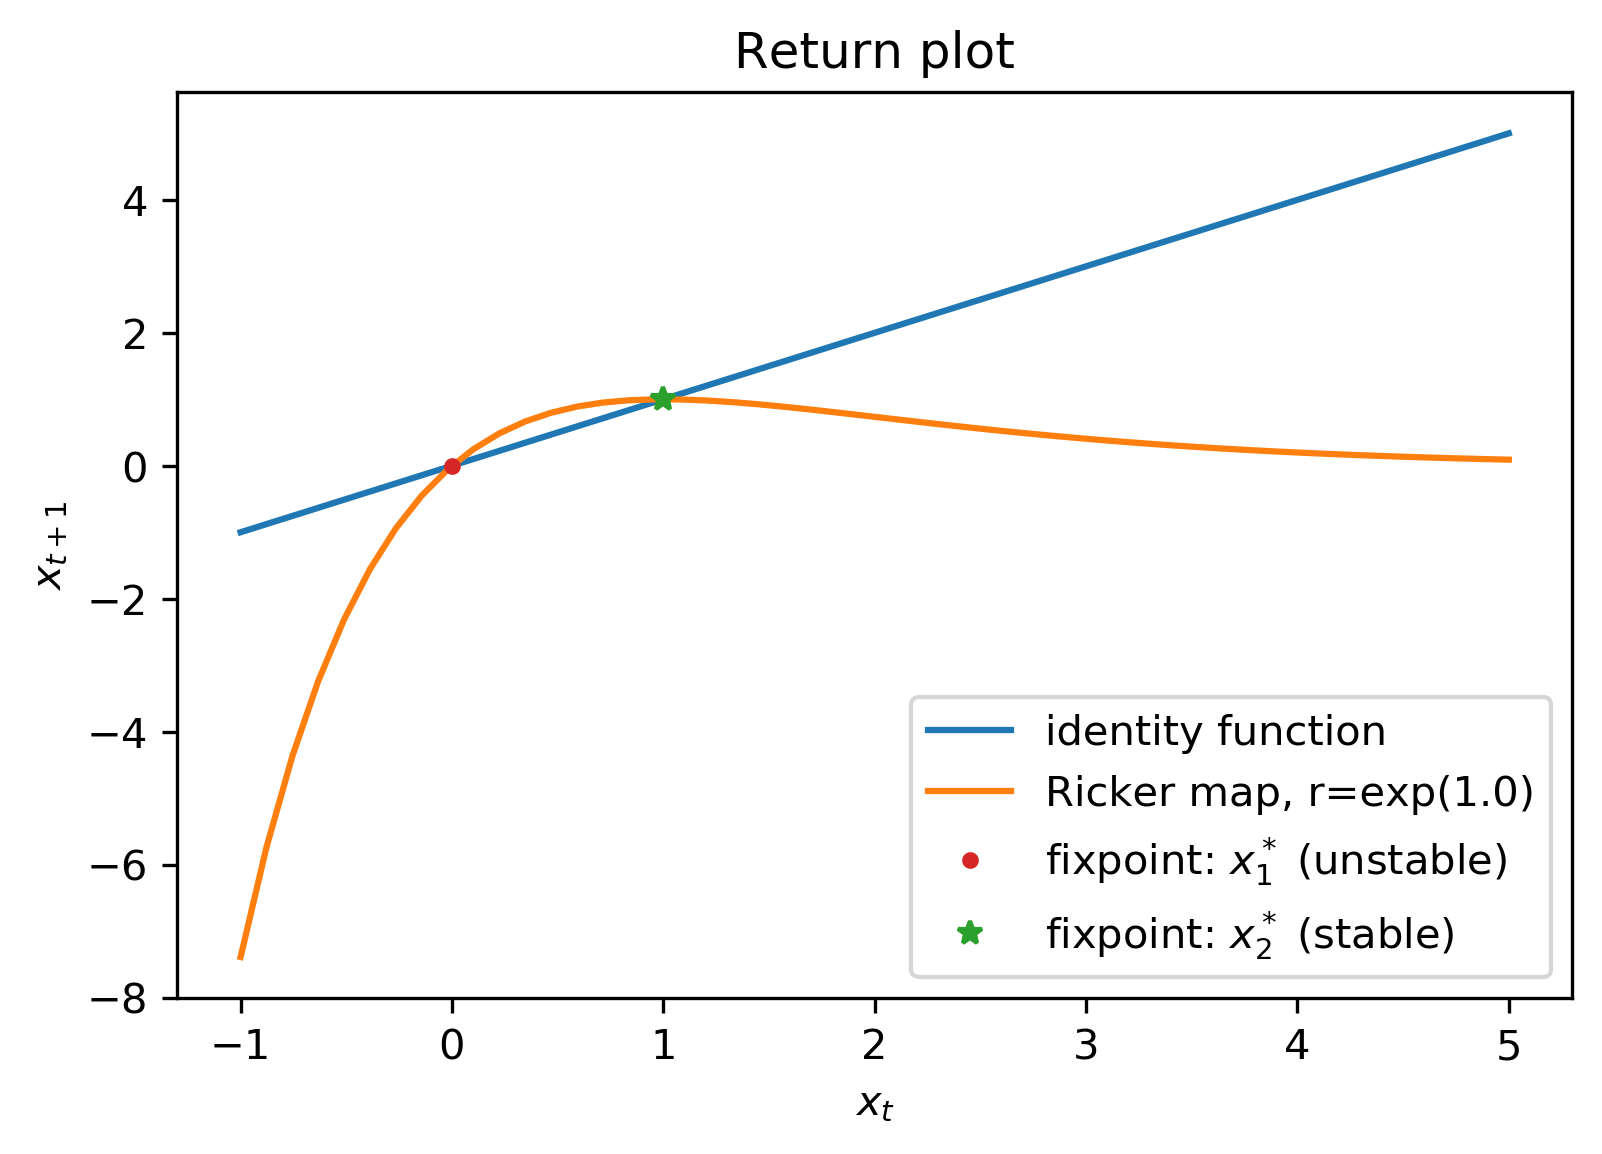

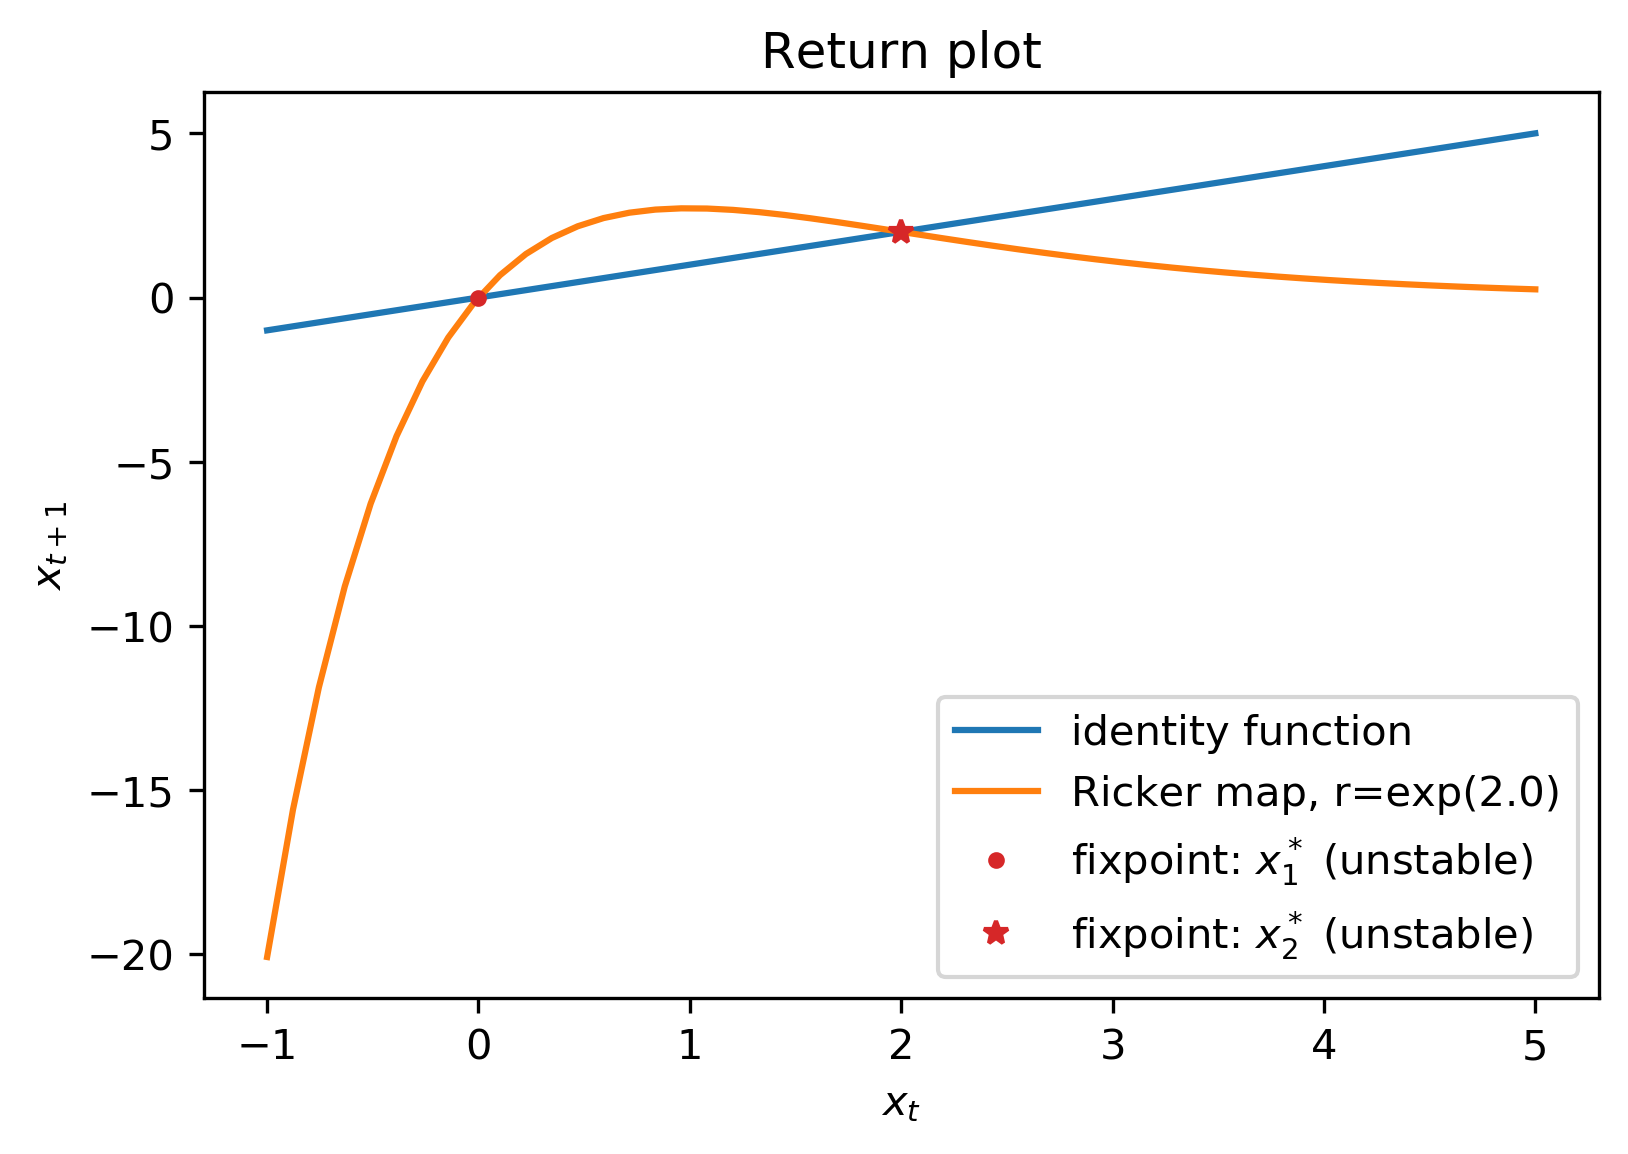

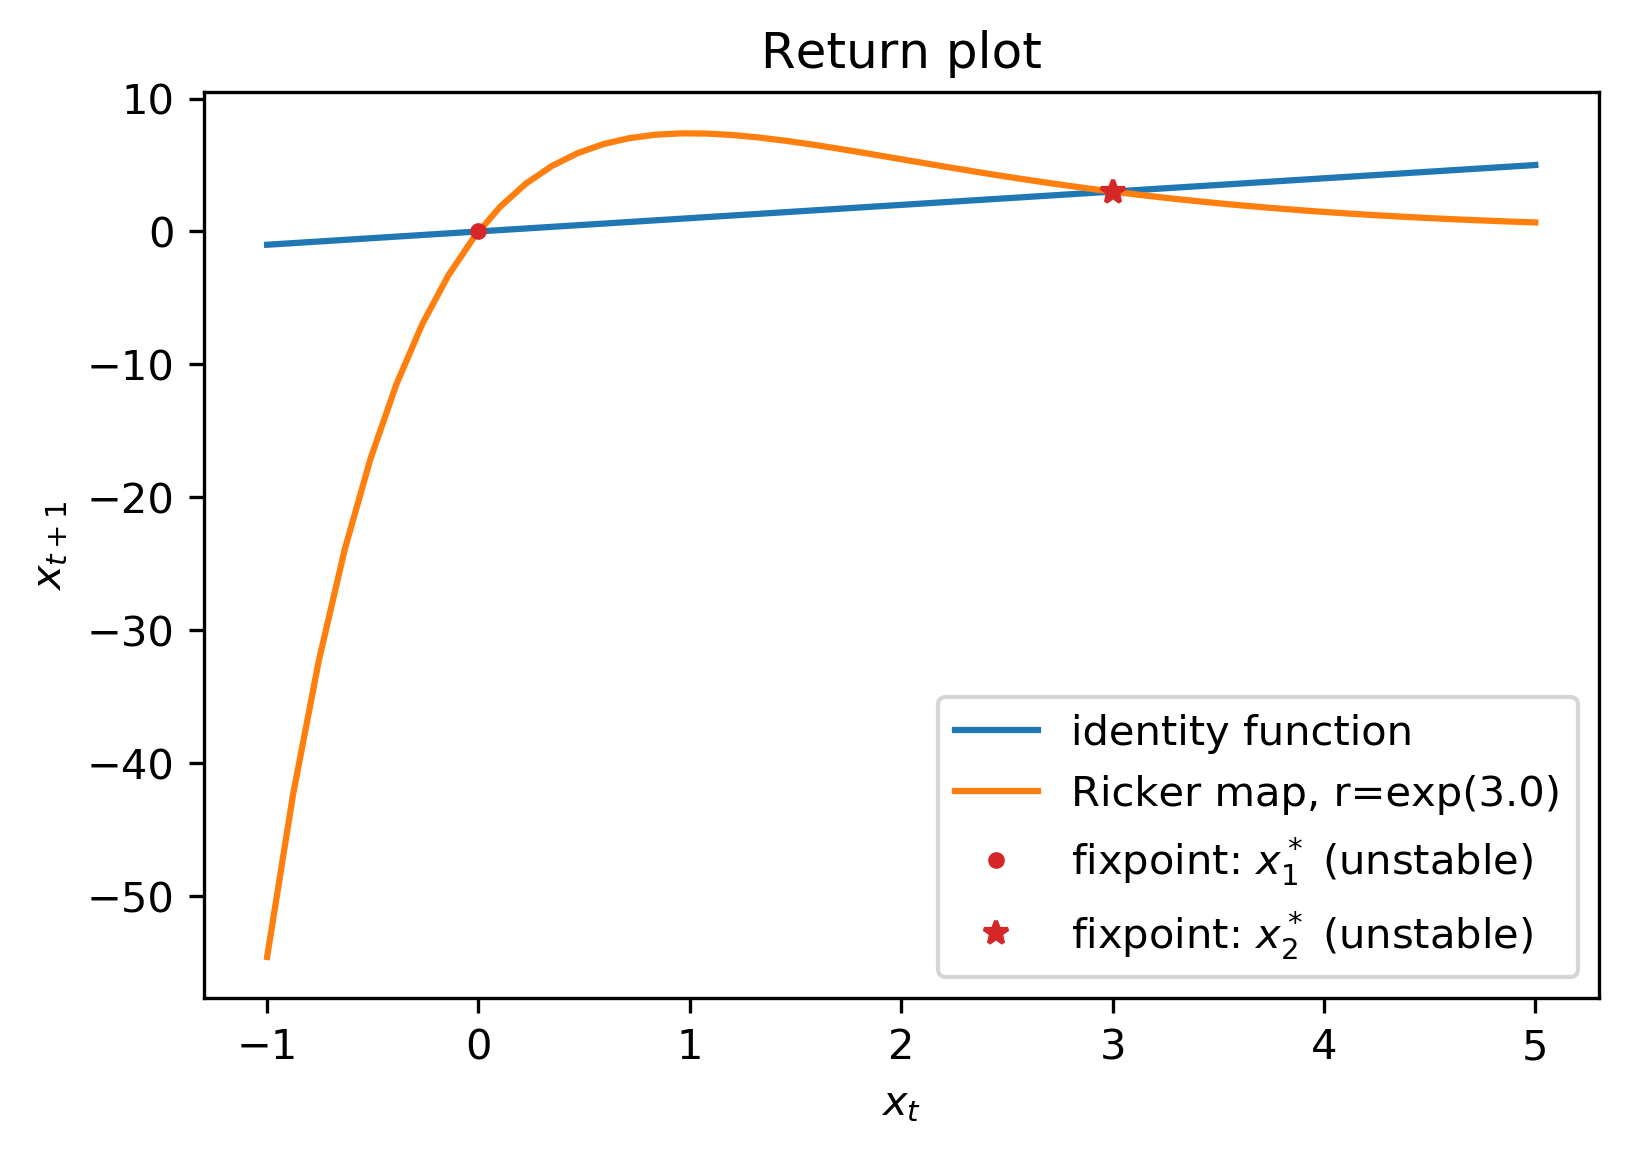

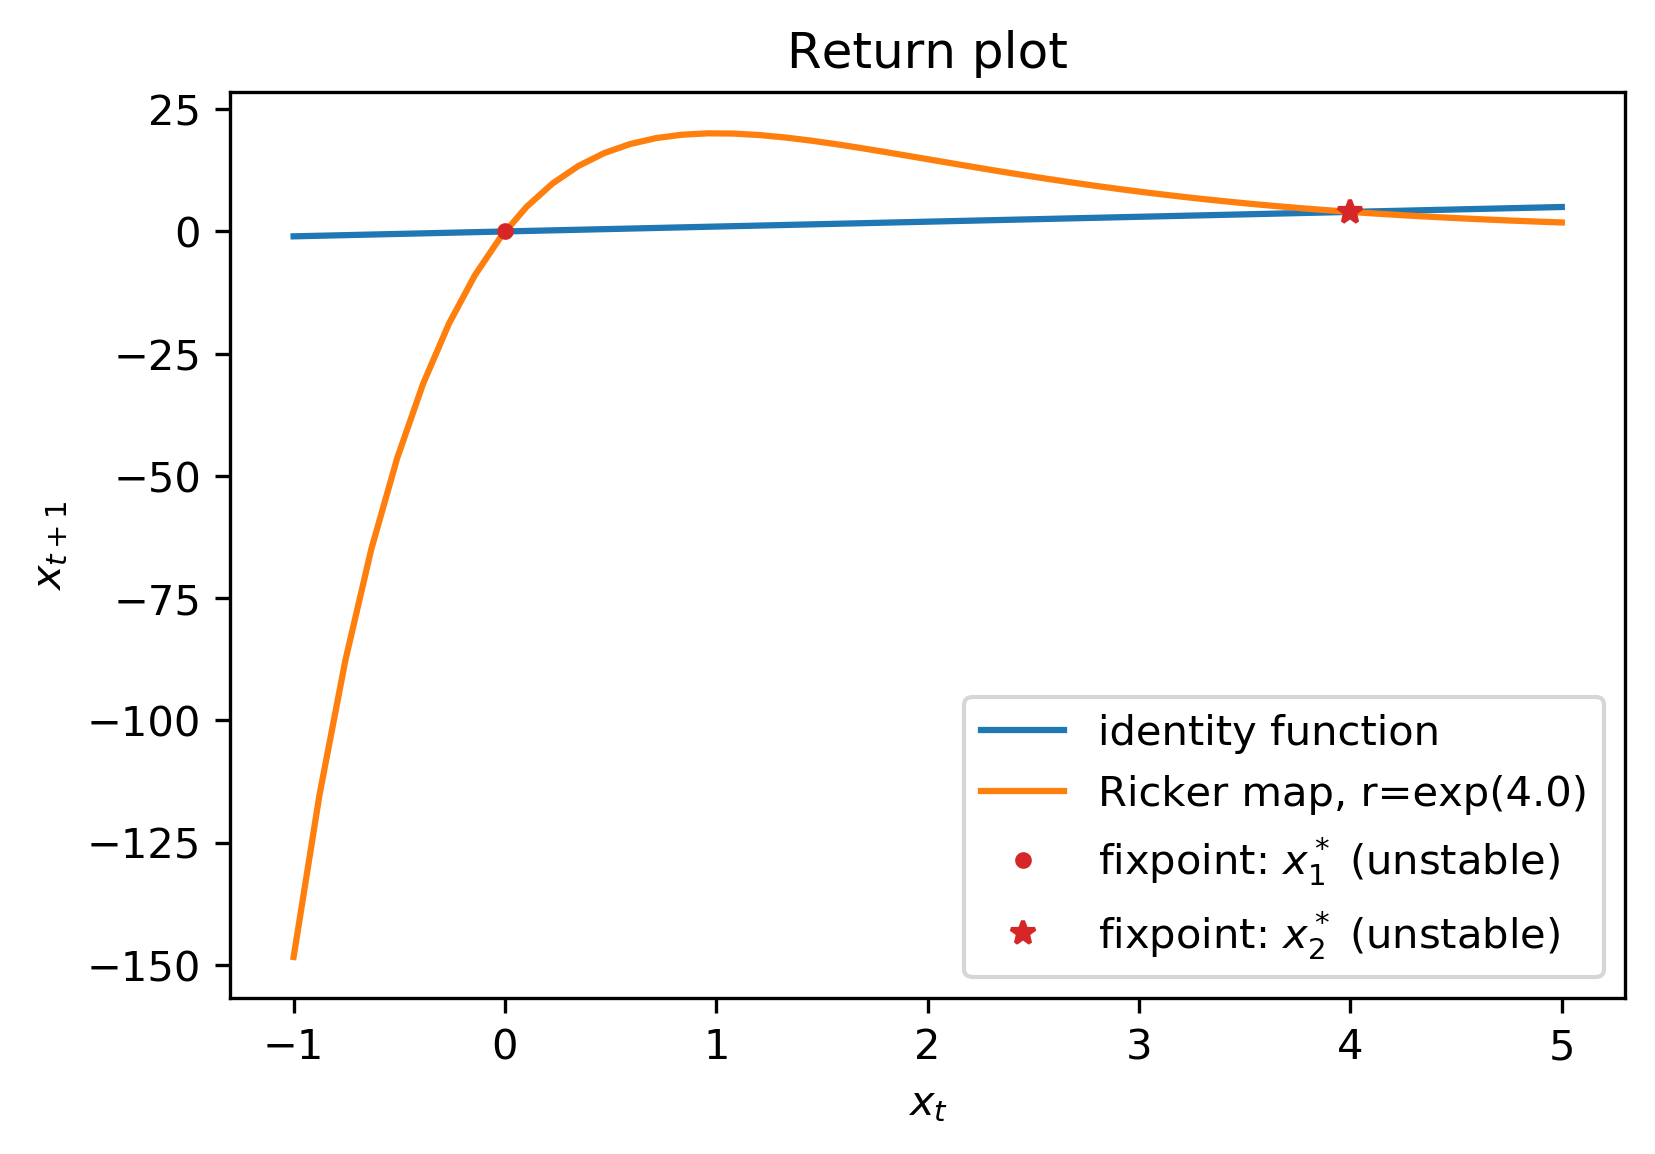

In [46]:
# Exploring the Ricker map
r_arr = np.exp([1, 2, 3, 4])
marker = ['.', '*']
for r in r_arr:
    x = np.linspace(-1, 5)
    x_out = ricker_map(x, r)
    x_fixpoints = np.array([0, np.log(r)])
    fix_diff = ricker_diff(x_fixpoints, r)

    plt.plot(x, x, label='identity function')
    plt.plot(x, x_out, label=f'Ricker map, r=exp({np.log(r)})')
    for i, x_fix in enumerate(x_fixpoints):
        if np.abs(fix_diff[i]) < 1:
            plt.plot(x_fix, x_fix, marker[i], c='tab:green', label=f'fixpoint: $x^*_{i+1}$ (stable)')
        else:
            plt.plot(x_fix, x_fix, marker[i], c='tab:red', label=f'fixpoint: $x^*_{i+1}$ (unstable)')
    plt.xlabel('$x_t$')
    plt.ylabel('$x_{t+1}$')
    plt.title('Return plot')
    plt.legend()
    plt.show()

<ipython-input-23-b0279178bfb0>:2: RuntimeWarning: overflow encountered in exp
  return r * x * np.exp(-x)


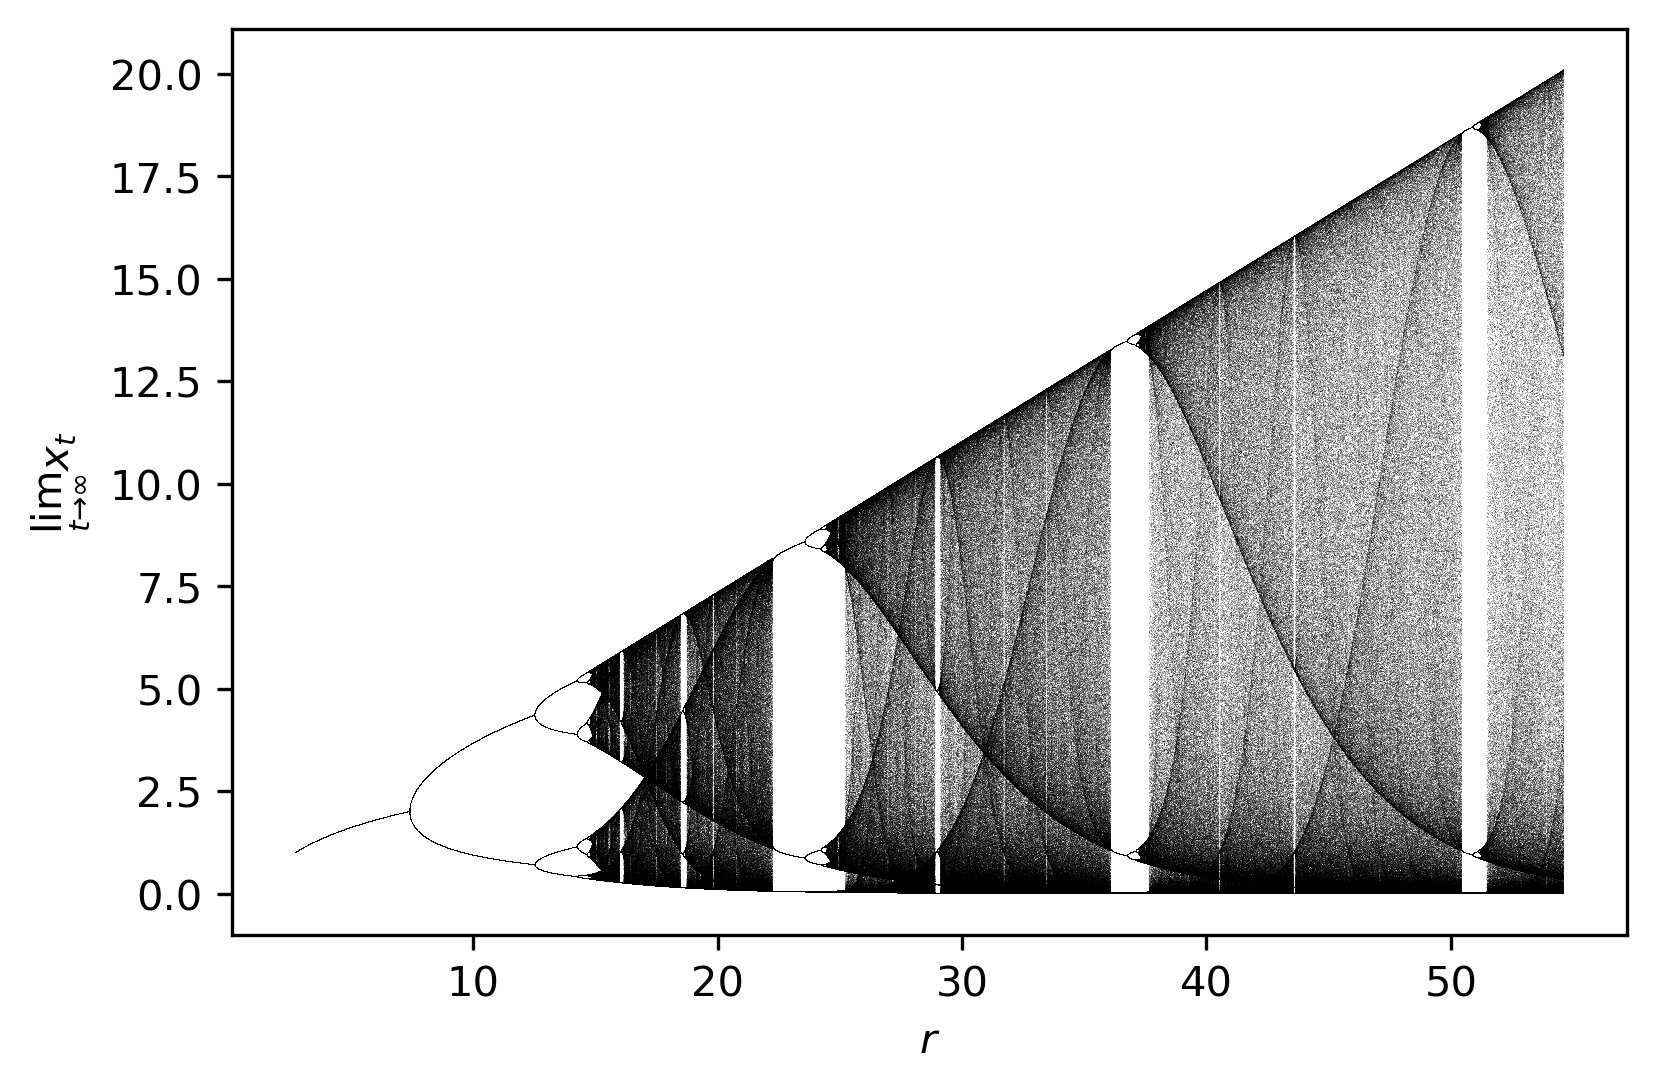

In [60]:
r = np.linspace(np.exp(1), np.exp(4), 10000) 
iterations = 1000                
display_last = 100               

x0_range = np.linspace(-1, 5, 5)
for x0 in x0_range: 
    x = np.ones_like(r) * x0
    for i in range(iterations):
        x = ricker_map(x, r)
        if i >= (iterations - display_last):
            plt.plot(r, x, ',k', alpha=0.25)
            
plt.xlabel('$r$')
plt.ylabel('$\lim_{t \\to \infty} x_t$')
plt.show()